In [20]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "신경망을 사용해 꽃 이미지 분류하기"

_nb_message = """이 노트북에서는 tf-flowers 데이터 세트를 분류하기 위해 신경망을 구축하는 방법을 보인다.
데이터 탐색은 대부분 02a_machine_perception.ipynb에서 수행했다.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84+%EC%82%AC%EC%9A%A9%ED%95%B4+%EA%BD%83+%EC%9D%B4%EB%AF%B8%EC%A7%80+%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/02_ml_models/02b_neural_network.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>신경망을 사용해 꽃 이미지 분류하기</h1>이 노트북에서는 tf-flowers 데이터 세트를 분류하기 위해 신경망을 구축하는 방법을 보인다.
데이터 탐색은 대부분 02a_machine_perception.ipynb에서 수행했다.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [4]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2


SystemError: ignored

In [5]:
# 도우미 함수들
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# 평가 데이터셋의 이미지 몇 개에 대해 model.predict()를 호출.
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES은 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1  # 레이어 0은 이미지를 병합, 레이어 1은 첫 번째 밀집 레이어
  WEIGHT_TYPE = 0  #0은 가중치, 1은 편향

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # 파일 읽기
  img = tf.io.read_file(filename)
  # 압축된 문자열을 3차원 uint8 텐서로 변환
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # [0,1] 범위의 부동 소수점으로 변환
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 이미지를 원하는 크기로 조정
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# 레이블은 CLASS_NAMES 배열의 인덱스
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 신경망(NN) 모델

중간에 비선형 레이어 한 개 추가 ...

In [7]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# 은닉층이 있는 NN
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 209s 2s/step - loss: 12.3644 - accuracy: 0.3406 - val_loss: 4.8526 - val_accuracy: 0.3676
Epoch 2/10
104/104 [==============================] - 174s 2s/step - loss: 5.8528 - accuracy: 0.3791 - val_loss: 4.2249 - val_accuracy: 0.4676
Epoch 3/10
104/104 [==============================] - 158s 2s/step - loss: 2.5182 - accuracy: 0.4518 - val_loss: 2.4724 - val_accuracy: 0.3730
Epoch 4/10
104/104 [==============================] - 121s 1s/step - loss: 1.8447 - accuracy: 0.4945 - val_loss: 2.5181 - val_accuracy: 0.3351
Epoch 5/10
104/104 [==============================] - 111s 1s/step - loss: 1.8043 - accuracy: 0.3903 - val_loss: 1.5224 - val_accuracy: 0.3054
Epoch 6/10
104/104 [==============================] - 107s 1s/step - loss: 1.4518 - accuracy: 0.3618 - val_loss: 1.7311 - val_accuracy: 0.2405
Epoch 7/10
104/104 [==============================] - 107s 1s/step - loss: 1.4681 - accuracy: 0.3285 - val_loss: 1.6469 - val_accuracy: 0.251

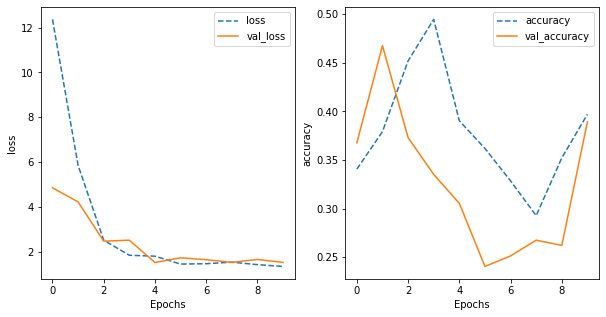

In [8]:
training_plot(['loss', 'accuracy'], history)

In [9]:
# 이전 셀의 값으로 매개변수화
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,  # Adam 생성자의 기본값
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32)  # 중요하지 않음

  # 은닉층이 한 개 있는 NN
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/10
104/104 [==============================] - 105s 1s/step - loss: 2.1675 - accuracy: 0.3606 - val_loss: 1.6294 - val_accuracy: 0.3676
Epoch 2/10
104/104 [==============================] - 107s 1s/step - loss: 1.6578 - accuracy: 0.4158 - val_loss: 1.5421 - val_accuracy: 0.4378
Epoch 3/10
104/104 [==============================] - 108s 1s/step - loss: 1.3799 - accuracy: 0.4664 - val_loss: 1.7640 - val_accuracy: 0.4270
Epoch 4/10
104/104 [==============================] - 108s 1s/step - loss: 1.3366 - accuracy: 0.4930 - val_loss: 1.8184 - val_accuracy: 0.4378
Epoch 5/10
104/104 [==============================] - 110s 1s/step - loss: 1.2928 - accuracy: 0.5233 - val_loss: 1.7369 - val_accuracy: 0.4378
Epoch 6/10
104/104 [==============================] - 108s 1s/step - loss: 1.1996 - accuracy: 0.5573 - val_loss: 1.5898 - val_accuracy: 0.4351
Epoch 7/10
104/104 [==============================] - 104s 995ms/step - loss: 1.1078 - accuracy: 0.5921 - val_loss: 1.5719 - val_accuracy: 0.4

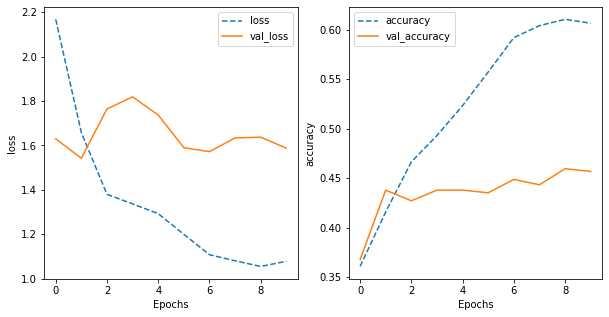

In [10]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 113s 1s/step - loss: 2.7658 - accuracy: 0.3573 - val_loss: 1.9491 - val_accuracy: 0.3081
Epoch 2/10
104/104 [==============================] - 114s 1s/step - loss: 1.4195 - accuracy: 0.4482 - val_loss: 1.9533 - val_accuracy: 0.3432
Epoch 3/10
104/104 [==============================] - 116s 1s/step - loss: 1.3655 - accuracy: 0.4618 - val_loss: 1.3940 - val_accuracy: 0.4514
Epoch 4/10
104/104 [==============================] - 110s 1s/step - loss: 1.1897 - accuracy: 0.5312 - val_loss: 1.4230 - val_accuracy: 0.4595
Epoch 5/10
104/104 [==============================] - 144s 1s/step - loss: 1.1480 - accuracy: 0.5539 - val_loss: 1.5566 - val_accuracy: 0.4541
Epoch 6/10
104/104 [==============================] - 134s 1s/step - loss: 1.0995 - accuracy: 0.5767 - val_loss: 1.4602 - val_accuracy: 0.4703
Epoch 7/10
104/104 [==============================] - 129s 1s/step - loss: 1.0428 - accuracy: 0.6036 - val_loss: 1.5766 - val_accuracy: 0.4514

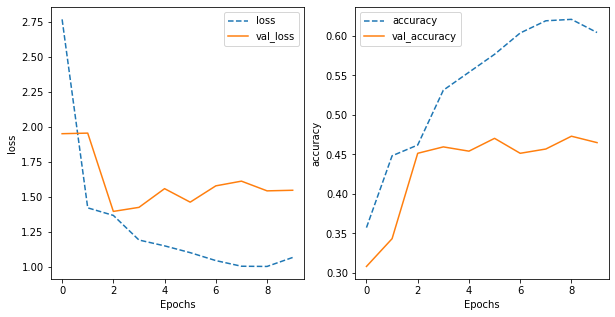

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 115s 1s/step - loss: 2.7159 - accuracy: 0.3521 - val_loss: 2.3785 - val_accuracy: 0.3189
Epoch 2/10
104/104 [==============================] - 115s 1s/step - loss: 1.8497 - accuracy: 0.4264 - val_loss: 1.8968 - val_accuracy: 0.4108
Epoch 3/10
104/104 [==============================] - 115s 1s/step - loss: 1.7796 - accuracy: 0.4306 - val_loss: 1.6850 - val_accuracy: 0.4297
Epoch 4/10
104/104 [==============================] - 114s 1s/step - loss: 1.6383 - accuracy: 0.4724 - val_loss: 1.6235 - val_accuracy: 0.4811
Epoch 5/10
104/104 [==============================] - 115s 1s/step - loss: 1.4193 - accuracy: 0.5318 - val_loss: 1.6394 - val_accuracy: 0.4649
Epoch 6/10
104/104 [==============================] - 111s 1s/step - loss: 1.3582 - accuracy: 0.5552 - val_loss: 1.6501 - val_accuracy: 0.4486
Epoch 7/10
104/104 [==============================] - 113s 1s/step - loss: 1.3854 - accuracy: 0.5561 - val_loss: 1.7049 - val_accuracy: 0.4568

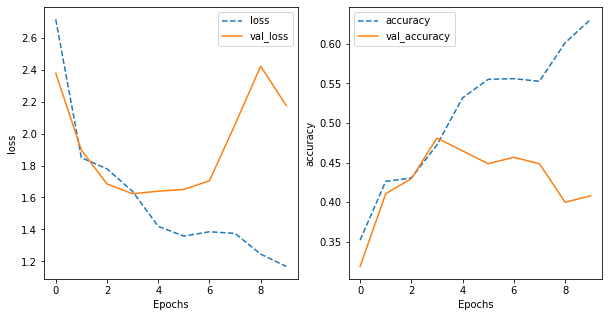

In [12]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## 하이퍼파라미터 튜닝

In [13]:
!pip install --quiet keras-tuner

     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 48.2 MB/s 


In [14]:
import kerastuner as kt

# 이전 셀의 값으로 매개변수화
def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int('num_hidden', 32, 256, 32)

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # 은닉층이 한 개 있는 NN
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(32)  # 중요하지 않음

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False)  # 새로 시작하려면 True

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

Trial 10 Complete [00h 11m 31s]
val_accuracy: 0.47567567229270935

Best val_accuracy So Far: 0.47567567229270935
Total elapsed time: 01h 08m 48s
{'lrate': 0.0001, 'l2': 0.01, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 38,536,709
Trainable params: 38,536,709
Non-trainable params: 0
_________________________________________________________________


None


In [15]:
topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())
  

{'lrate': 0.0001, 'l2': 0.01, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 38,536,709
Trainable params: 38,536,709
Non-trainable params: 0
_________________________________________________________________


None


## 심층 신경망(DNN)

DNN을 학습시키자.
레이어 수와 각 레이어의 노드 수를 매개변수화한다.

In [16]:
# 이전 셀의 값으로 매개변수화
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # 은닉층이 여러 개 있는 신경망
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 125s 1s/step - loss: 1.8997 - accuracy: 0.3330 - val_loss: 1.5453 - val_accuracy: 0.4027
Epoch 2/10
104/104 

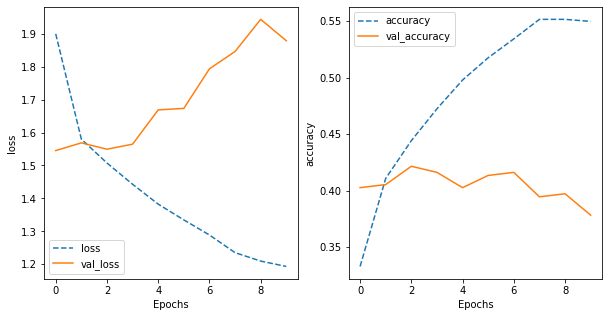

In [17]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

### 드롭아웃과 배치 정규화
각 은닉층 뒤에 드롭아웃과 배치 정규화 레이어를 추가한다.

In [18]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32)  # 중요하지 않음

  # 은닉층이 여러 개 있는 NN
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  for hno, nodes in enumerate(num_hidden):
    layers.extend([
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
      tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
      # 활성화를 배치 정규화 다음에 오도록 이동
      tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
      tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense_{}'.format(hno)),                         
    ])

  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  )

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 batchnorm_dense_0 (BatchNor  (None, 64)               128       
 malization)                                                     
                                                                 
 relu_dense_0 (Activation)   (None, 64)                0         
                                                                 
 dropout_dense_0 (Dropout)   (None, 64)                0         
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                             

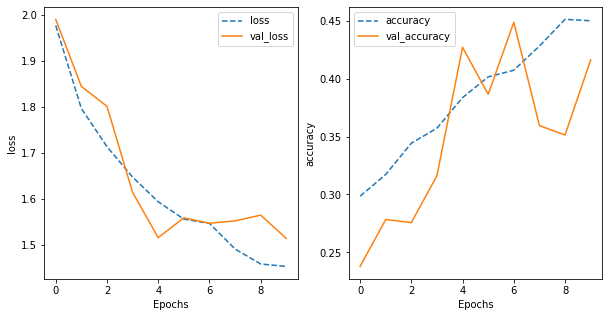

In [19]:
model = train_and_evaluate(dropout_prob=0.4)

## 도표

책에 넣을 도표.

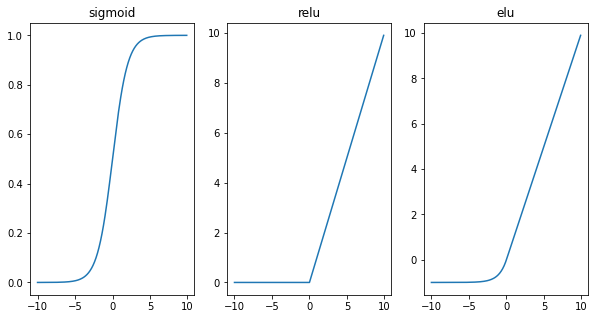

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


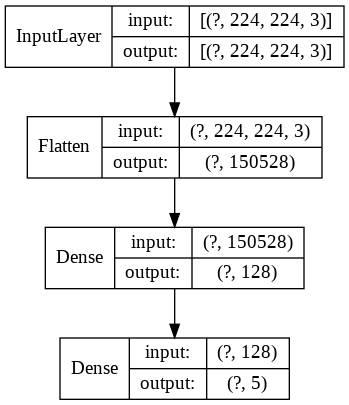

In [ ]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.